# IL HW4
# MAZE Problem
Ali Saeizadeh
810196477

## Initialization

In [13]:
from model import NSFrozenLake
import numpy as np
from amalearn.agent import AgentBase
import sys
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [14]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

ACTIONS = [LEFT,DOWN,RIGHT,UP]
ACTIONS_STRING = ['\u2190','\u2193','\u2192','\u2191']
print(ACTIONS_STRING)

['←', '↓', '→', '↑']


In [15]:
REPS = 20
EPISODES = 100
EPSILON = 0.1
LEARNING_RATE = 0.1
DISCOUNT = 0.9
STUDENT_NUM = 810196477

In [16]:
class NSFrozenLake_modeified(NSFrozenLake):
    def state_action_space(self):
        states = [(x, y) for x in range(self.map.shape[0])
                  for y in range(self.map.shape[1])]
        counter = list(range(0, len(states)))
        S = dict(zip(counter, states))
        S_inv = dict(zip(states, counter))
        return S, ACTIONS, S_inv

    def get_state(self):
        return self.state

In [17]:
env = NSFrozenLake_modeified(STUDENT_NUM)
env.render()


------------------------------
| 0.000 | 0.181 | 0.467 | 0.018 | 
------------------------------
| 0.001 | 0.092 | 0.622 | 0.358 | 
------------------------------
| 0.001 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.153 | 0.717 | 0.942 | 0.000 | 
------------------------------


## Question 1: Value Iteration

In [18]:
class Agent_Value_Policy(AgentBase):
    def __init__(self, id, environment, discount, theta):
        self.env = environment
        self.S, self.A, self.S_inv = self.env.state_action_space()
        self.Q_value = np.zeros((len(self.A), len(self.S)))
        self.V = {s: 0 for s in range(0, len(self.S))}
        self.policy = {s: 0 for s in range(0, len(self.S))}
        self.discount = discount
        self.theta = theta
        self.Q = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        self.current_state = self.env.get_state()
        super(Agent_Value_Policy, self).__init__(id, environment)

    def value_iteration(self):
        while True:
            delta = 0
            for s in self.S:
                action_val = np.zeros(len(self.A))
                old_V = self.V[s]
                next_states = self.env.possible_consequences(0, self.S[s])[0]
                for a in self.A:
                    V_s = np.zeros(len(next_states))
                    for s_next_idx, s_next in enumerate(next_states):
                        V_s[s_next_idx] = self.env.possible_consequences(a, self.S[s])[1][s_next_idx] * (env.possible_consequences(a, self.S[s])[2][s_next_idx] * -10 + (env.possible_consequences(
                            a, self.S[s])[3][s_next_idx] == True) * 50 + (1 - self.env.possible_consequences(a, self.S[s])[2][s_next_idx]) * -1 + self.discount * self.V[self.S_inv[s_next]])
                    action_val[a] = np.sum(V_s)
                self.V[s] = np.max(action_val)
                delta = max(delta, abs(old_V - self.V[s]))
            if(delta < self.theta):
                break

        for s in self.S:
            action_val = np.zeros(len(self.A))
            old_V = self.V[s]
            next_states = self.env.possible_consequences(0, self.S[s])[0]
            for a in self.A:
                V_s = np.zeros(len(next_states))
                for s_next_idx, s_next in enumerate(next_states):
                    V_s[s_next_idx] = self.env.possible_consequences(a, self.S[s])[1][s_next_idx] * ((env.possible_consequences(a, self.S[s])[2][s_next_idx] * -10 + 0) + (env.possible_consequences(
                        a, self.S[s])[3][s_next_idx] == True) * 50 + (1 - self.env.possible_consequences(a, self.S[s])[2][s_next_idx]) * -1 + self.discount * self.V[self.S_inv[s_next]])
                action_val[a] = np.sum(V_s)
                self.Q_value[a, s] = action_val[a]

            self.Q[self.S[s]] = action_val
            self.policy[s] = np.argmax(action_val)

    def solve(self):
        start_time = time.time()
        print("\rSolving...",end="")
        self.value_iteration()
        sys.stdout.flush()
        print("\rFinding Solution took: {:.2f} seconds".format(time.time() - start_time), end="\n")
        return self.policy

    def take_action(self):
        action = self.policy[self.S_inv[self.current_state]]
        s, r, d, obs = self.env.step(action)
        self.current_state = s
        return s, r, d, obs

    def optimal_action(self):
        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                out += "{:s} | ".format(ACTIONS_STRING[self.policy[self.S_inv[(i, j)]]])
        out += "\n------------------------------"
        print(out)

    def get_average_reward(self, max_time, num_episodes, window_size):
        rewrads = np.zeros([num_episodes, max_time])
        ep_rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': []}
        for i_episode in range(1, num_episodes + 1):
            self.current_state = self.env.reset()
            for t in range(max_time):
                _, rewrads[i_episode - 1, t], d, _ = self.take_action()
                if(d):
                    break
            episode_reward = np.sum(rewrads[i_episode - 1, :])
            ep_rewards.append(episode_reward)
            if not i_episode % window_size:
                    average_reward = sum(ep_rewards[-window_size:])/window_size
                    aggr_ep_rewards['ep'].append(i_episode)
                    aggr_ep_rewards['avg'].append(average_reward)
                    print("\rEpisode {}/{} | average reward: {}.".format(
                        i_episode, num_episodes, average_reward), end="")
                    sys.stdout.flush()
        return aggr_ep_rewards

    def get_q_values(self):
        return self.Q

    def get_policy(self):
        return self.policy



In [19]:
discount = 0.9
theta = 0.1
num_episodes = 1
num_run = 1
window_size = 100
max_time = 30

env = NSFrozenLake_modeified(STUDENT_NUM)
env.render()
agent_value_policy = Agent_Value_Policy(0, env, discount, theta)
agent_value_policy.solve()
agent_value_policy.optimal_action()
print('Q((0,0),a) = ', agent_value_policy.get_q_values()[(0,0)])


------------------------------
| 0.000 | 0.181 | 0.467 | 0.018 | 
------------------------------
| 0.001 | 0.092 | 0.622 | 0.358 | 
------------------------------
| 0.001 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.153 | 0.717 | 0.942 | 0.000 | 
------------------------------
Finding Solution took: 6.80 seconds

------------------------------
| ↓ | ↓ | → | ↓ | 
------------------------------
| ↓ | ↓ | ↓ | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
Q((0,0),a) =  [228.07610151 253.15324827 250.4650731  228.07610151]


Finding Solution took: 7.13 seconds
Episode 4000/4000 | average reward: 34.38.

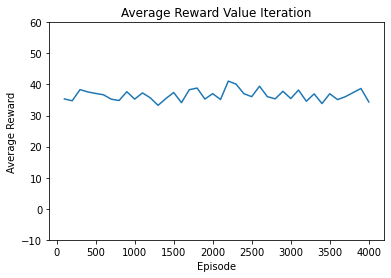

In [20]:
discount = 0.9
theta = 0.1
num_episodes = 4000
window_size = 100
max_time = 30

env = NSFrozenLake_modeified(studentNum=STUDENT_NUM)
agent_value_policy = Agent_Value_Policy(0, env, discount, theta)
agent_value_policy.solve()
aggr_ep_rewards = agent_value_policy.get_average_reward(max_time, num_episodes, window_size)
plt.plot(aggr_ep_rewards['ep'],aggr_ep_rewards['avg'], label="average rewards")
plt.title("Average Reward Value Iteration")
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()

## Question 2: Model Free Methods

### Question 2.1 Monte Carlo Off-Policy

In [21]:
def greedy_policy(Q):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

def epsilon_greedy_policy(Q, epsilon):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float) + 1
        A = A * epsilon/len(A)
        best_action = np.argmax(Q[state])
        A[best_action] += 1 - epsilon
        return A
    return policy_fn

In [22]:
class Agent_Off_Policy(AgentBase):
    def __init__(self, id, environment, discount, epsilon, trial, window_size=50,  e_decay=False):
        self.env = environment
        self.epsilon_init = epsilon
        self.epsilon = epsilon
        self.num_episodes = trial
        self.window_size = window_size
        self.e_decay = e_decay
        self.discount_factor = discount
        self.S, self.A, self.S_inv = self.env.state_action_space()
        self.policy = {s: 0 for s in range(0, len(self.S))}
        self.discount = discount
        self.theta = theta
        self.current_state = self.env.get_state()
        self.Q = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        self.C = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        super(Agent_Off_Policy, self).__init__(id, environment)

    def off_policy_mc(self):
        target_policy = greedy_policy(self.Q)
        max_time = 30
        ep_rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': []}

        for i_episode in range(1, self.num_episodes+1):
            episode = []
            episode_reward = 0
            state = self.env.reset()

            if(self.e_decay):
                self.epsilon *= 0.995

            target_policy = greedy_policy(self.Q)
            behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
            for t in range(max_time):
                probs = behavior_policy(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                next_state, reward, done, _ = self.env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward
                if done:
                    break
                state = next_state

            G = 0.0
            W = 1.0
            for t in range(len(episode))[::-1]:
                state, action, reward = episode[t]
                G = self.discount_factor * G + reward
                self.C[state][action] += W
                self.Q[state][action] += (W / self.C[state]
                                          [action]) * (G - self.Q[state][action])
                if action != np.argmax(target_policy(state)):
                    break
                W = W * 1./behavior_policy(state)[action]

            ep_rewards.append(episode_reward)
            if not i_episode % self.window_size:
                average_reward = sum(
                    ep_rewards[-self.window_size:])/self.window_size
                aggr_ep_rewards['ep'].append(i_episode)
                aggr_ep_rewards['avg'].append(average_reward)
                print("\rEpisode {}/{} | average reward: {}, current epsilon: {}.".format(
                    i_episode, self.num_episodes, average_reward, self.epsilon), end="")
                sys.stdout.flush()

        for s in self.S:
            self.policy[s] = np.argmax(self.Q[self.S[s]])

        return aggr_ep_rewards

    def take_action(self):
        action = self.policy[self.S_inv[self.current_state]]
        s, r, d, obs = self.environment.step(action)
        self.current_state = s
        return s, r, d, obs

    def optimal_action(self):
        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                out += "{:s} | ".format(
                    ACTIONS_STRING[self.policy[self.S_inv[(i, j)]]])
        out += "\n------------------------------"
        print(out)
        
    def get_policy(self):
        return self.policy

Episode 4000/4000 | average reward: 38.32.
Run 19: Constant Epsilon
Episode 4000/4000 | average reward: 33.08, current epsilon: 0.1.
Run 19: Decaying Epsilon
Episode 4000/4000 | average reward: 40.19, current epsilon: 1.960301999536469e-09..

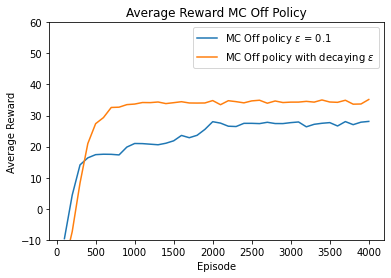

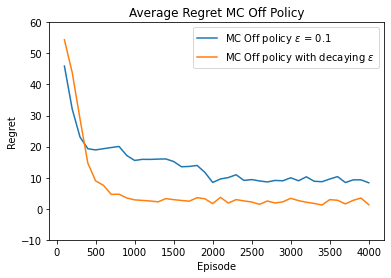

Average Number of Action Diffrence with Optimal Policy 5.58/16.00
Average Number of Action Diffrence with Optimal Policy 5.68/16.00

------------------------------
| ↓ | ↓ | ← | ↓ | 
------------------------------
| ↓ | ↓ | ← | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
| ↑ | ↑ | → | ← | 
------------------------------

------------------------------
| ↓ | ↓ | → | ← | 
------------------------------
| ↓ | ↓ | ↓ | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
| ↑ | ↑ | → | ← | 
------------------------------


In [24]:
discount = 0.9
theta = 0.1
trial = 4000
num_run = 20
win_size = 100
alpha = 0.5

regret_1 = []
regret_2 = []
rewards_1 = []
rewards_2 = []
diff_s_1 = []
diff_s_2 = []

env = NSFrozenLake_modeified(STUDENT_NUM)
agent_value_policy = Agent_Value_Policy(0, env, discount, theta)
agent_value_policy.solve()
optimal_policy = agent_value_policy.get_policy()

for r in range(1, num_run):
    clear_output(wait=True)
    rewards_opt = agent_value_policy.get_average_reward(max_time, trial, win_size)['avg']

    print("\nRun {}: Constant Epsilon".format(r), end="\n")
    agent_mc_off_policy_1 = Agent_Off_Policy(0, env, discount, 0.1, trial, win_size,  False)
    avg_rewards = agent_mc_off_policy_1.off_policy_mc()['avg']
    policy = agent_mc_off_policy_1.get_policy()

    rewards_1.append(avg_rewards)
    regret_1.append(np.array(rewards_opt) - np.array(avg_rewards))
    diff_s_1.append(len([k for k in policy if policy[k] != optimal_policy[k]]))

    print("\nRun {}: Decaying Epsilon".format(r), end="\n")
    agent_mc_off_policy_2 = Agent_Off_Policy(0, env, discount, 1, trial, win_size, True)
    avg_rewards = agent_mc_off_policy_2.off_policy_mc()['avg']
    policy = agent_mc_off_policy_2.get_policy()

    rewards_2.append(avg_rewards)
    regret_2.append(np.array(rewards_opt) - np.array(avg_rewards))
    diff_s_2.append(len([k for k in policy if policy[k] != optimal_policy[k]]))


ep_idx = list(range(win_size, trial + win_size, win_size))

plt.plot(ep_idx,np.average(rewards_1,axis=0), label="MC Off policy $\epsilon$ = 0.1")
plt.plot(ep_idx,np.average(rewards_2,axis=0), label="MC Off policy with decaying $\epsilon$")
plt.legend()
plt.title("Average Reward MC Off Policy")
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()


plt.plot(ep_idx,np.average(regret_1,axis=0), label="MC Off policy $\epsilon$ = 0.1")
plt.plot(ep_idx,np.average(regret_2,axis=0), label="MC Off policy with decaying $\epsilon$")
plt.legend()
plt.title("Average Regret MC Off Policy")
plt.ylabel('Regret')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()

print('Average Number of Action Diffrence with Optimal Policy {:.2f}/{:.2f}'.format(np.average(diff_s_1),len(optimal_policy)))
print('Average Number of Action Diffrence with Optimal Policy {:.2f}/{:.2f}'.format(np.average(diff_s_2),len(optimal_policy)))

agent_mc_off_policy_1.optimal_action()
agent_mc_off_policy_2.optimal_action()

### Question 2.2: Q-Learning

In [25]:
def greedy_policy(Q):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

def epsilon_greedy_policy(Q, epsilon):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float) + 1
        A = A * epsilon/len(A)
        best_action = np.argmax(Q[state])
        A[best_action] += 1 - epsilon
        return A
    return policy_fn

In [26]:
class Agent_Q_Learning(AgentBase):
    def __init__(self, id, environment, discount, alpha, trial, window_size=50,  a_decay=False):
        self.env = environment
        self.alpha = alpha
        self.epsilon = 0.1
        self.a_decay = a_decay
        self.num_episodes = trial
        self.window_size = window_size
        self.discount_factor = discount
        self.S, self.A, self.S_inv = self.env.state_action_space()
        self.policy = {s: 0 for s in range(0, len(self.S))}
        self.discount = discount
        self.theta = theta
        self.current_state = self.env.get_state()
        self.Q = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        super(Agent_Q_Learning, self).__init__(id, environment)

    def q_learning(self):
        behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
        max_time = 30
        ep_rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': []}

        for i_episode in range(1, self.num_episodes+1):
            episode = []
            episode_reward = 0
            state = self.env.reset()

            if(self.a_decay):
                self.alpha *= 0.995
            
            behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
            for t in range(max_time):
                probs = behavior_policy(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                next_state, reward, done, _ = self.env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward

                best_next_action = np.argmax(self.Q[next_state])    
                td_target = reward + self.discount_factor * self.Q[next_state][best_next_action]
                td_delta = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_delta
                if done:
                    break
                state = next_state

            ep_rewards.append(episode_reward)
            if not i_episode % self.window_size:
                average_reward = sum(
                    ep_rewards[-self.window_size:])/self.window_size
                aggr_ep_rewards['ep'].append(i_episode)
                aggr_ep_rewards['avg'].append(average_reward)
                print("\rEpisode {}/{} | average reward: {}, current alpha: {}.".format(
                    i_episode, self.num_episodes, average_reward, self.alpha), end="")
                sys.stdout.flush()

        for s in self.S:
            self.policy[s] = np.argmax(self.Q[self.S[s]])

        return aggr_ep_rewards

    def take_action(self):
        action = self.policy[self.S_inv[self.current_state]]
        s, r, d, obs = self.environment.step(action)
        self.current_state = s
        return s, r, d, obs

    def optimal_action(self):
        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                out += "{:s} | ".format(
                    ACTIONS_STRING[self.policy[self.S_inv[(i, j)]]])
        out += "\n------------------------------"
        print(out)

    def get_policy(self):
        return self.policy

Episode 2000/2000 | average reward: 34.92.
Run 19: Constant alpha
Episode 2000/2000 | average reward: 30.29, current alpha: 0.1.
Run 19: Decaying alpha
Episode 2000/2000 | average reward: 23.93, current alpha: 4.4275297848083e-05.5.

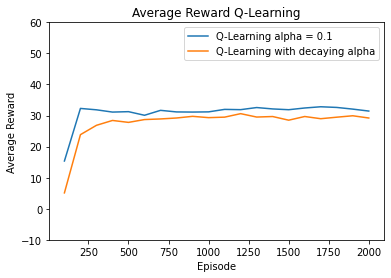

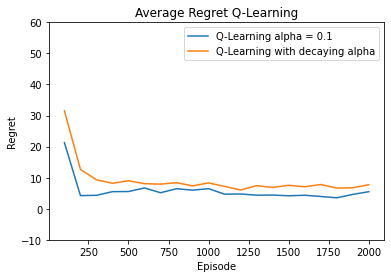

Average Number of Action Diffrence with Optimal Policy 5.16/16.00
Average Number of Action Diffrence with Optimal Policy 6.05/16.00

------------------------------
| ↓ | ↓ | → | ↓ | 
------------------------------
| → | ↓ | ↓ | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
| ↑ | ↑ | ← | ← | 
------------------------------

------------------------------
| ↓ | ← | ↓ | ↓ | 
------------------------------
| → | ↓ | ← | ↓ | 
------------------------------
| ↑ | → | → | ↓ | 
------------------------------
| ↑ | ↑ | ← | ← | 
------------------------------


In [27]:
discount = 0.9
theta = 0.1
trial = 2000
num_run = 20
win_size = 100
alpha = 0.5

regret_1 = []
regret_2 = []
rewards_1 = []
rewards_2 = []
diff_s_1 = []
diff_s_2 = []

env = NSFrozenLake_modeified(STUDENT_NUM)
agent_value_policy = Agent_Value_Policy(0, env, discount, theta)
agent_value_policy.solve()
optimal_policy = agent_value_policy.get_policy()

for r in range(1, num_run):
    clear_output(wait=True)
    rewards_opt = agent_value_policy.get_average_reward(max_time, trial, win_size)['avg']

    print("\nRun {}: Constant alpha".format(r), end="\n")
    agent_q_learning_1 = Agent_Q_Learning(0, env, discount, 0.1, trial, win_size, False)
    avg_rewards = agent_q_learning_1.q_learning()['avg']
    policy = agent_q_learning_1.get_policy()

    rewards_1.append(avg_rewards)
    regret_1.append(np.array(rewards_opt) - np.array(avg_rewards))
    diff_s_1.append(len([k for k in policy if policy[k] != optimal_policy[k]]))

    print("\nRun {}: Decaying alpha".format(r), end="\n")
    agent_q_learning_2 = Agent_Q_Learning(0, env, discount, 1, trial, win_size, True)
    avg_rewards = agent_q_learning_2.q_learning()['avg']
    policy = agent_q_learning_2.get_policy()

    rewards_2.append(avg_rewards)
    regret_2.append(np.array(rewards_opt) - np.array(avg_rewards))
    diff_s_2.append(len([k for k in policy if policy[k] != optimal_policy[k]]))


ep_idx = list(range(win_size, trial + win_size, win_size))

plt.plot(ep_idx,np.average(rewards_1,axis=0), label="Q-Learning alpha = 0.1")
plt.plot(ep_idx,np.average(rewards_2,axis=0), label="Q-Learning with decaying alpha")
plt.legend()
plt.title("Average Reward Q-Learning")
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()


plt.plot(ep_idx,np.average(regret_1,axis=0), label="Q-Learning alpha = 0.1")
plt.plot(ep_idx,np.average(regret_2,axis=0), label="Q-Learning with decaying alpha")
plt.legend()
plt.title("Average Regret Q-Learning")
plt.ylabel('Regret')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()

print('Average Number of Action Diffrence with Optimal Policy {:.2f}/{:.2f}'.format(np.average(diff_s_1),len(optimal_policy)))
print('Average Number of Action Diffrence with Optimal Policy {:.2f}/{:.2f}'.format(np.average(diff_s_2),len(optimal_policy)))

agent_q_learning_1.optimal_action()
agent_q_learning_2.optimal_action()

### Question 2.3 SARSA and 2-Step Tree Backup

In [28]:
def greedy_policy(Q):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

def epsilon_greedy_policy(Q, epsilon):
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float) + 1
        A = A * epsilon/len(A)
        best_action = np.argmax(Q[state])
        A[best_action] += 1 - epsilon
        return A
    return policy_fn

#### SARSA

In [29]:
class Agent_Sarsa(AgentBase):
    def __init__(self, id, environment, discount, alpha, trial, window_size=50):
        self.env = environment
        self.alpha = alpha
        self.epsilon = 0.1
        self.num_episodes = trial
        self.window_size = window_size
        self.discount_factor = discount
        self.S, self.A, self.S_inv = self.env.state_action_space()
        self.policy = {s: 0 for s in range(0, len(self.S))}
        self.discount = discount
        self.theta = theta
        self.current_state = self.env.get_state()
        self.Q = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        super(Agent_Sarsa, self).__init__(id, environment)

    def sarsa(self):
        behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
        max_time = 30
        ep_rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': []}

        for i_episode in range(1, self.num_episodes+1):
            episode = []
            episode_reward = 0
            state = self.env.reset()

            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)

            for t in range(max_time):
                next_state, reward, done, _ = self.env.step(action)
                next_action_probs = behavior_policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                
                episode.append((state, action, reward))
                episode_reward += reward
 
                td_target = reward + self.discount_factor * self.Q[next_state][next_action]
                td_delta = td_target - self.Q[state][action]
                self.Q[state][action] += self.alpha * td_delta

                if done:
                    break

                state = next_state
                action = next_action

            ep_rewards.append(episode_reward)
            if not i_episode % self.window_size:
                average_reward = sum(
                    ep_rewards[-self.window_size:])/self.window_size
                aggr_ep_rewards['ep'].append(i_episode)
                aggr_ep_rewards['avg'].append(average_reward)
                print("\rEpisode {}/{} | average reward: {}".format(i_episode, self.num_episodes, average_reward), end="")
                sys.stdout.flush()

        for s in self.S:
            self.policy[s] = np.argmax(self.Q[self.S[s]])

        return aggr_ep_rewards

    def take_action(self):
        action = self.policy[self.S_inv[self.current_state]]
        s, r, d, obs = self.environment.step(action)
        self.current_state = s
        return s, r, d, obs

    def optimal_action(self):
        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                out += "{:s} | ".format(
                    ACTIONS_STRING[self.policy[self.S_inv[(i, j)]]])
        out += "\n------------------------------"
        print(out)
        
    def get_policy(self):
        return self.policy

#### 2-Step Tree Backup

In [30]:
class Agent_Tree_Backup(AgentBase):
    def __init__(self, id, environment, discount, alpha, trial, window_size=50):
        self.env = environment
        self.alpha = alpha
        self.epsilon = 0.1
        self.num_episodes = trial
        self.window_size = window_size
        self.discount_factor = discount
        self.S, self.A, self.S_inv = self.env.state_action_space()
        self.Q_value = np.zeros((len(self.A), len(self.S)))
        self.V = {s: 0 for s in range(0, len(self.S))}
        self.policy = {s: 0 for s in range(0, len(self.S))}
        self.discount = discount
        self.theta = theta
        self.current_state = self.env.get_state()
        self.Q = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        self.C = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        super(Agent_Tree_Backup, self).__init__(id, environment)

    def two_step_tree_backup(self):
        max_time = 30
        ep_rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': []}

        for i_episode in range(1, self.num_episodes+1):
            episode = []
            episode_reward = 0
            state = self.env.reset()

            behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)

            for t in range(max_time):
                T = np.inf
                behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
                action_probs = behavior_policy(state)
                action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

                next_state, reward, done, _ = env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward

                next_action_probs = behavior_policy(next_state)
                next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
                    
                next_next_state, next_reward, done, _ = env.step(next_action)

                episode.append((next_next_state, next_action, next_reward))
                episode_reward += next_reward
                

                next_next_action_probs = behavior_policy(next_next_state)
                next_next_action = np.random.choice(np.arange(len(next_next_action_probs)), p=next_next_action_probs)

                G = next_reward + self.discount_factor * np.sum(next_next_action_probs * self.Q[next_next_state])
                G = reward + self.discount_factor * (np.sum(next_action_probs * self.Q[next_state]) - next_action_probs[next_action] * self.Q[next_state][next_action]) + self.discount_factor * next_action_probs[next_action] * G
                td_delta = G - self.Q[state][action]

                self.Q[state][action] += alpha * td_delta

                if done:
                    break

                state = next_next_state

            ep_rewards.append(episode_reward)
            if not i_episode % self.window_size:
                average_reward = sum(
                    ep_rewards[-self.window_size:])/self.window_size
                aggr_ep_rewards['ep'].append(i_episode)
                aggr_ep_rewards['avg'].append(average_reward)
                print("\rEpisode {}/{} | average reward: {}, .".format(i_episode, self.num_episodes, average_reward), end="")
                sys.stdout.flush()

        for s in self.S:
            self.policy[s] = np.argmax(self.Q[self.S[s]])
            
        return aggr_ep_rewards

    def take_action(self):
        action = self.policy[self.S_inv[self.current_state]]
        s, r, d, obs = self.environment.step(action)
        self.current_state = s
        return s, r, d, obs

    def optimal_action(self):
        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                out += "{:s} | ".format(
                    ACTIONS_STRING[self.policy[self.S_inv[(i, j)]]])
        out += "\n------------------------------"
        print(out)
        
    def get_policy(self):
        return self.policy


Episode 2000/2000 | average reward: 37.66.
Run 19: SARSA
Episode 2000/2000 | average reward: 27.342
Run 19: 2-Step Tree Backup
Episode 2000/2000 | average reward: 26.64, .

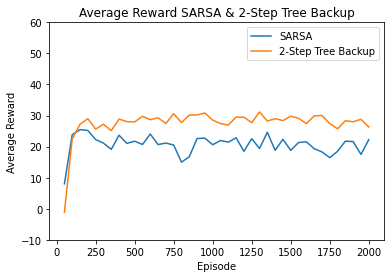

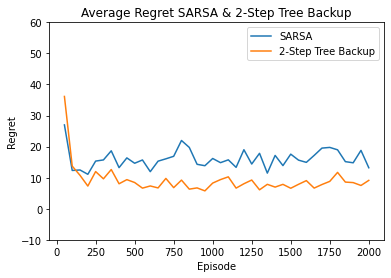

Average Number of Action Diffrence with Optimal Policy 5.53/16.00
Average Number of Action Diffrence with Optimal Policy 6.89/16.00

------------------------------
| ↑ | ↓ | ↑ | ↓ | 
------------------------------
| ↓ | ↓ | ↓ | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
| ↑ | ↑ | → | ← | 
------------------------------

------------------------------
| ↓ | ↓ | ← | ↓ | 
------------------------------
| ↓ | ↓ | ← | ↓ | 
------------------------------
| → | → | → | ↓ | 
------------------------------
| ↑ | ↑ | → | ← | 
------------------------------


In [31]:
discount = 0.9
theta = 0.1
trial = 2000
num_run = 20
win_size = 50
alpha = 0.5

regret_1 = []
regret_2 = []
rewards_1 = []
rewards_2 = []
diff_s_1 = []
diff_s_2 = []

env = NSFrozenLake_modeified(STUDENT_NUM)
agent_value_policy = Agent_Value_Policy(0, env, discount, theta)
agent_value_policy.solve()
optimal_policy = agent_value_policy.get_policy()

for r in range(1, num_run):
    clear_output(wait=True)
    rewards_opt = agent_value_policy.get_average_reward(max_time, trial, win_size)['avg']

    print("\nRun {}: SARSA".format(r), end="\n")
    agent_sarsa = Agent_Sarsa(0, env, discount, alpha, trial, win_size)
    avg_rewards = agent_sarsa.sarsa()['avg']
    policy = agent_sarsa.get_policy()

    rewards_1.append(avg_rewards)
    regret_1.append(np.array(rewards_opt) - np.array(avg_rewards))
    diff_s_1.append(len([k for k in policy if policy[k] != optimal_policy[k]]))

    print("\nRun {}: 2-Step Tree Backup".format(r), end="\n")
    agent_two_step = Agent_Tree_Backup(0, env, discount, alpha, trial, win_size)
    avg_rewards = agent_two_step.two_step_tree_backup()['avg']
    policy = agent_two_step.get_policy()

    rewards_2.append(avg_rewards)
    regret_2.append(np.array(rewards_opt) - np.array(avg_rewards))
    diff_s_2.append(len([k for k in policy if policy[k] != optimal_policy[k]]))


ep_idx = list(range(win_size, trial + win_size, win_size))

plt.plot(ep_idx,np.average(rewards_1,axis=0), label="SARSA")
plt.plot(ep_idx,np.average(rewards_2,axis=0), label="2-Step Tree Backup")
plt.legend()
plt.title("Average Reward SARSA & 2-Step Tree Backup")
plt.ylabel('Average Reward')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()


plt.plot(ep_idx,np.average(regret_1,axis=0), label="SARSA")
plt.plot(ep_idx,np.average(regret_2,axis=0), label="2-Step Tree Backup")
plt.legend()
plt.title("Average Regret SARSA & 2-Step Tree Backup")
plt.ylabel('Regret')
plt.xlabel('Episode')
plt.ylim((-10,60))
plt.show()

print('Average Number of Action Diffrence with Optimal Policy {:.2f}/{:.2f}'.format(np.average(diff_s_1),len(optimal_policy)))
print('Average Number of Action Diffrence with Optimal Policy {:.2f}/{:.2f}'.format(np.average(diff_s_2),len(optimal_policy)))

agent_sarsa.optimal_action()
agent_two_step.optimal_action()

## Question 3


In [32]:
env = NSFrozenLake_modeified(STUDENT_NUM, True)
env.render()


------------------------------
| 0.000 | 0.181 | 0.467 | 0.018 | 
------------------------------
| 0.001 | 0.092 | 0.622 | 0.358 | 
------------------------------
| 0.001 | 0.001 | 0.001 | 0.001 | 
------------------------------
| 0.153 | 0.717 | 0.942 | 0.000 | 
------------------------------


In [33]:
class Agent_Mixed(AgentBase):
    def __init__(self, id, environment, discount, alpha,w,Q_model_based, trial, window_size=50):
        self.env = environment
        self.alpha = alpha
        self.w = w
        self.epsilon = 0.1
        self.num_episodes = trial
        self.window_size = window_size
        self.discount_factor = discount
        self.S, self.A, self.S_inv = self.env.state_action_space()
        self.V = {s: 0 for s in range(0, len(self.S))}
        self.policy = {s: 0 for s in range(0, len(self.S))}
        self.discount = discount
        self.theta = theta
        self.current_state = self.env.get_state()
        self.Q = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}

        self.Q_model_free = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}

        self.Q_model_based = Q_model_based

        self.C = {(x, y): np.zeros(len(self.env.state_action_space()[1])) for x in range(len(
            self.env.state_action_space()[0])) for y in range(len(self.env.state_action_space()[0]))}
        super(Agent_Mixed, self).__init__(id, environment)

    def mixed(self):
        behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
        max_time = 30
        ep_rewards = []
        aggr_ep_rewards = {'ep': [], 'avg': []}
        
        for i_episode in range(1, self.num_episodes+1):
            episode = []
            episode_reward = 0
            state = self.env.reset()

            behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
            for t in range(max_time):
                behavior_policy = epsilon_greedy_policy(self.Q, self.epsilon)
                probs = behavior_policy(state)
                action = np.random.choice(np.arange(len(probs)), p=probs)
                next_state, reward, done, _ = self.env.step(action)
                episode.append((state, action, reward))
                episode_reward += reward

                best_next_action = np.argmax(self.Q_model_free[next_state])    
                td_target = reward + self.discount_factor * self.Q_model_free[next_state][best_next_action]
                td_delta = td_target - self.Q_model_free[state][action]
                self.Q_model_free[state][action] += self.alpha * td_delta

                self.Q[state][action] = self.w * self.Q_model_free[state][action] + (1 - self.w) * self.Q_model_based[state][action]
                if done:
                    break
                state = next_state

            ep_rewards.append(episode_reward)
            if not i_episode % self.window_size:
                average_reward = sum(
                    ep_rewards[-self.window_size:])/self.window_size
                aggr_ep_rewards['ep'].append(i_episode)
                aggr_ep_rewards['avg'].append(average_reward)
                print("\rEpisode {}/{} | average reward: {}, current w: {}.".format(
                    i_episode, self.num_episodes, average_reward, self.w), end="")
                sys.stdout.flush()

        for s in self.S:
            self.policy[s] = np.argmax(self.Q[self.S[s]])

        return aggr_ep_rewards

    def take_action(self):
        action = self.policy[self.S_inv[self.current_state]]
        s, r, d, obs = self.environment.step(action)
        self.current_state = s
        return s, r, d, obs

    def optimal_action(self):
        out = ""
        for i in range(4):
            out += "\n------------------------------\n| "
            for j in range(4):
                out += "{:s} | ".format(
                    ACTIONS_STRING[self.policy[self.S_inv[(i, j)]]])
        out += "\n------------------------------"
        print(out)

Episode 10000/10000 | average reward: 18.68, current w: 1.

(-20.0, 60.0)

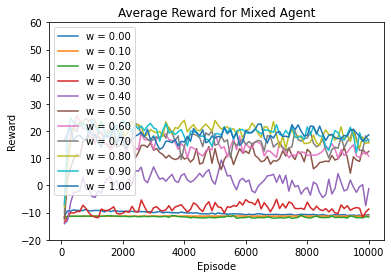

In [34]:
discount = 0.9
theta = 0.1
trial = 10000
num_run = 20
win_size = 100
alpha = 0.5


aggr_ep_rewards = []

env = NSFrozenLake_modeified(STUDENT_NUM, True)
agent_value_policy = Agent_Value_Policy(0, env, discount, theta)
agent_value_policy.solve()
Q_model_based = agent_value_policy.get_q_values()

W = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
aggr_ep_idx = list(range(win_size, trial + win_size, win_size))
 
for w in W:
    aggr_ep_rewards = []
    for r in range(1, num_run):
        clear_output(wait=True)
        agent_mixed = Agent_Mixed(0, env, discount, alpha, w,Q_model_based, trial, win_size)
        aggr_ep_rewards.append(agent_mixed.mixed()['avg'])
    plt.plot(aggr_ep_idx, np.average(aggr_ep_rewards, axis=0), label="w = {:.2f}".format(w))

plt.legend()
plt.title("Average Reward for Mixed Agent")
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.ylim((-20, 60))